In [ ]:
import pandas as pd

When you are developing in a module, it's really handy to have these lines:

In [ ]:
%load_ext autoreload
%autoreload 2

We want to see debug-level logging in the notebook. Here's the incantation:

In [ ]:
import logging
from src.logging import logger
logger.setLevel(logging.DEBUG)

# Raw Data is Read Only: Sing it with me!

How do you asseble raw data into a usable dataset? How do you make sure your raw datasets are reproducible?
We are going to work through the process of collecting raw data files (using an object called a `RawDataset`), and converting them into something useful for our reproducible data science workflow (the `Dataset` object).

A raw dataset is really just a list of files (and some useful metadata) that is later processed into a usable dataset. From a data provenance perspective, the most important things to know about raw data are:
* Raw data is **hash-verified**. This ensures that if something changes upstream, we know about that change.
* Raw data is **read only**, and is used to generate a separate and reproducible **Dataset** object
* Raw data is **not saved** in the source code repository. (in fact, the whole `data` directory is specifically excluded in our `.gitignore`). Instead, the recipe for obtaining and processing the raw data is saved. A snapshot of the raw data can be synced with a large data repo, like an AWS bucket, if desired.

Our approach to building a usable dataset is:

1. Assemble the raw data files. Generate (and record) hashes to ensure the validity of these files.
2. Add LICENSE and DESCR (description) metadata to make the raw data usable for other people, and
3. Write a function to process the raw data into a usable format (for us, a `Dataset` object)
4. Write transformation functions on `Dataset` objects that fit our data munging into an automated reproducible workflow

Let's build our first `Dataset`.


## Bjørn's Problem: Supervised Learning

Bjørn employs a large number of Finnish line cooks. He can’t understand a word they say.

Bjørn needs a trained model to do real-time translation from Finnish to Swedish.

Bjørn has decided to start with the Finnish phoneme dataset shipped with a project called lvq-pak. His objective is to train three different models, and choose the one with the best overall accuracy score.


### LVQ-Pak: A Finnish Phonetic dataset

The Learning Vector Quantization (lvq-pak) project includes a simple Finnish phonetic dataset
consisting 20-dimensional Mel Frequency Cepstrum Coefficients (MFCCs) labelled with target phoneme information. Our goal is to explore this dataset, process it into a useful form, and make it a part of a reproducible data science workflow.

In [ ]:
dataset_name='lvq-pak'  # Naming things: the hardest problem in computer science.

## Assemble the Raw Data Files
lvq-pak is shipped as a source code tarball. The data files are included as textfiles within that download. Our first goal is to retrieve these source files, and record some metadata about them.

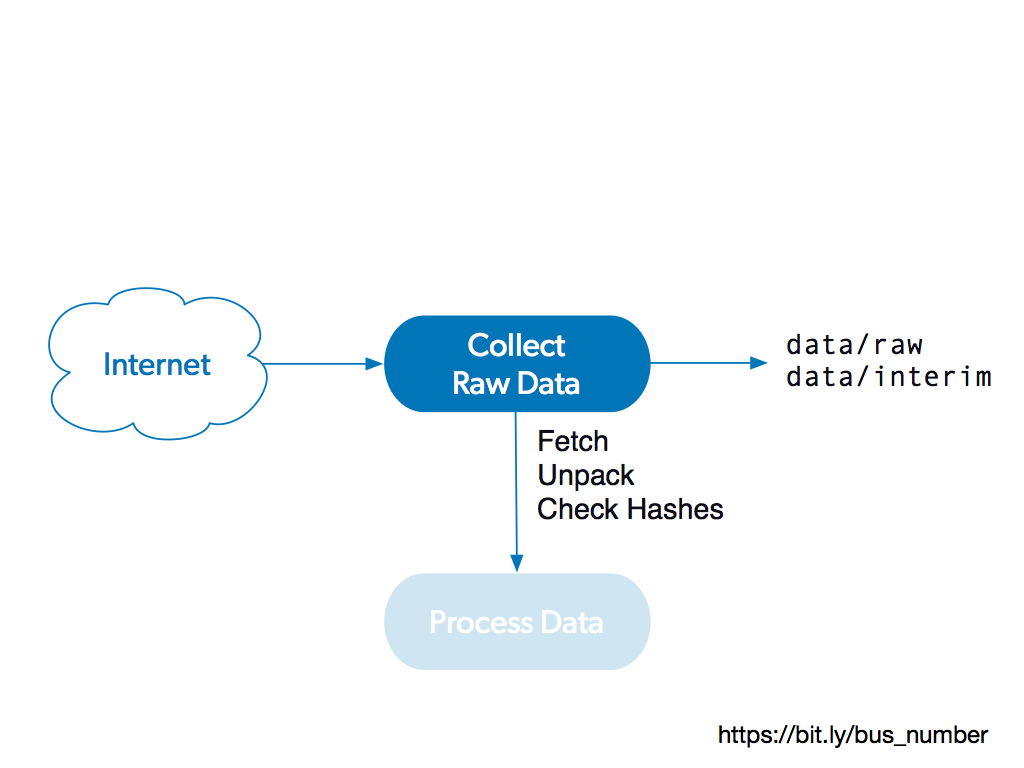

### But first...Data Directories, `paths` and `pathlib`

Recall from our `README.md` the locations of our data files

* `data`
    * Data directory. often symlinked to a filesystem with lots of space
    * `data/raw` 
        * Raw (immutable) hash-verified downloads
    * `data/interim` 
        * Extracted and interim data representations, such as caches
    * `data/processed` 
        * The final, cleaned and processed data sets for modeling.

However, we **do not want to hardcode these paths** in our scripts.  This is what our `src.paths` module is for.

In [ ]:
from src.paths import raw_data_path, interim_data_path, processed_data_path

**A quick aside**: we will be using `Pathlib` under the hood so that our paths are platform independant. **Use `Pathlib`!** Read more here:https://realpython.com/python-pathlib/.

Let's check out what's in these directories already...they should, at this stage, be empty.

In [ ]:
# Makes exploring from a notebook a bit easier
from src.utils import list_dir

In [ ]:
print(f"{raw_data_path}")
list_dir(raw_data_path)

### Download and Check Hashes
Let's fetch the source files for lvq-pak and check (or generate) their hashes. The object we use to house this information is a `RawDataset`.

In [ ]:
from src.data import RawDataset


We can add a file to the RawDataset using its `add_url()` method. If we know the hash of this file, we should include it here, and it will be checked on download. If not, one will be computed from this download and used for comparison on subsequent downloads.


In [ ]:
lvq_pak = RawDataset(dataset_name)
lvq_pak.add_url(url="http://www.cis.hut.fi/research/lvq_pak/lvq_pak-3.1.tar")

### Add License and Description
Before we can turn this raw data into a usable dataset, we need to know two things:
1. What does the raw data look like? Where did I get it from? What format is it in? What should it look like when it's processed? (`DESCR`)
2. Am I allowed to use this data? (`LICENSE`)

There are some additional options to `add_url()` we may wish to use for this purpose.

In [ ]:
help(RawDataset.add_url)

* `hash_value` and `hash_type` should be self-evident.
* `file_name` is optional. If skipped, the name will be guessed from the URL. It's often nice to specify, however, so you can use this attribute to override the default guess.
* The `name` field can either be used to specify a text label to describe the dataset. It can also be used to tag two special pieces of metadata: `DESCR` and `LICENSE`, the downloaded (text) file will be used as the dataset description and license text, respectively.

We will use this feature to add a `README` to our dataset:

In [ ]:
lvq_pak.add_url(url='http://www.cis.hut.fi/research/lvq_pak/README',
                file_name=f'{dataset_name}.readme',
                name='DESCR')

Datasets should ***always* have an explicit license**. Reading the project documentation, we see a license in one of the textfiles.

In [ ]:
license_txt = '''
************************************************************************
*                                                                      *
*                              LVQ_PAK                                 *
*                                                                      *
*                                The                                   *
*                                                                      *
*                   Learning  Vector  Quantization                     *
*                                                                      *
*                          Program  Package                            *
*                                                                      *
*                   Version 3.1 (April 7, 1995)                        *
*                                                                      *
*                          Prepared by the                             *
*                    LVQ Programming Team of the                       *
*                 Helsinki University of Technology                    *
*           Laboratory of Computer and Information Science             *
*                Rakentajanaukio 2 C, SF-02150 Espoo                   *
*                              FINLAND                                 *
*                                                                      *
*                      Copyright (c) 1991-1995                         *
*                                                                      *
************************************************************************
*                                                                      *
*  NOTE: This program package is copyrighted in the sense that it      *
*  may be used for scientific purposes. The package as a whole, or     *
*  parts thereof, cannot be included or used in any commercial         *
*  application without written permission granted by its producents.   *
*  No programs contained in this package may be copied for commercial  *
*  distribution.                                                       *
*                                                                      *
*  All comments concerning this program package may be sent to the     *
*  e-mail address 'lvq@nucleus.hut.fi'.                                *
*                                                                      *
************************************************************************
'''

We can extract and use the license via the `add_metadata()` method:

In [ ]:
lvq_pak.add_metadata(contents=license_txt, kind='LICENSE')

### Fetching the Data

We're ready to download the data. Now that we've set up our `RawDataset`, all we have to do now is `fetch()` it.

In [ ]:
lvq_pak.fetch()

In [ ]:
from src.utils import list_dir
from src.paths import raw_data_path
list_dir(raw_data_path)

## Unpack the data
How do we turn these raw files into processed data?

First, we need to unpack them. Fortunately, the `RawDataset` object knows how to unpack or decompress most common archive formats.

In [ ]:
untar_dir = lvq_pak.unpack()
print(untar_dir)

By default, raw data is unpacked to `interim_data_path` in a directory corresponding to the `dataset_name`

In [ ]:
list_dir(interim_data_path / dataset_name)

## Converting a `RawDataset` into a usable `Dataset`

What's a `Dataset` object?
It's a scikit-learn-style `Bunch`, containing:
* `data`: the processed data
* `target`: (optional) target vector (for supervised learning problems)
* `metadata`: Data about the data

Under the hood, this is basically a dictionary.

We run `process()` to turn a `RawDataset` into a `Dataset`.

Suppose we do that right now.

In [ ]:
ds = lvq_pak.process()

We now have a `Dataset` object.

In [ ]:
print(ds)

While this `Dataset` has metdata:

In [ ]:
print(ds.LICENSE)

In [ ]:
print(ds.DESCR)

The `Dataset` doesn't actually have any data yet. In particular, `data` and `target` are empty.

In [ ]:
ds.data

In [ ]:
ds.target

Let's fix that.

## Processing the data


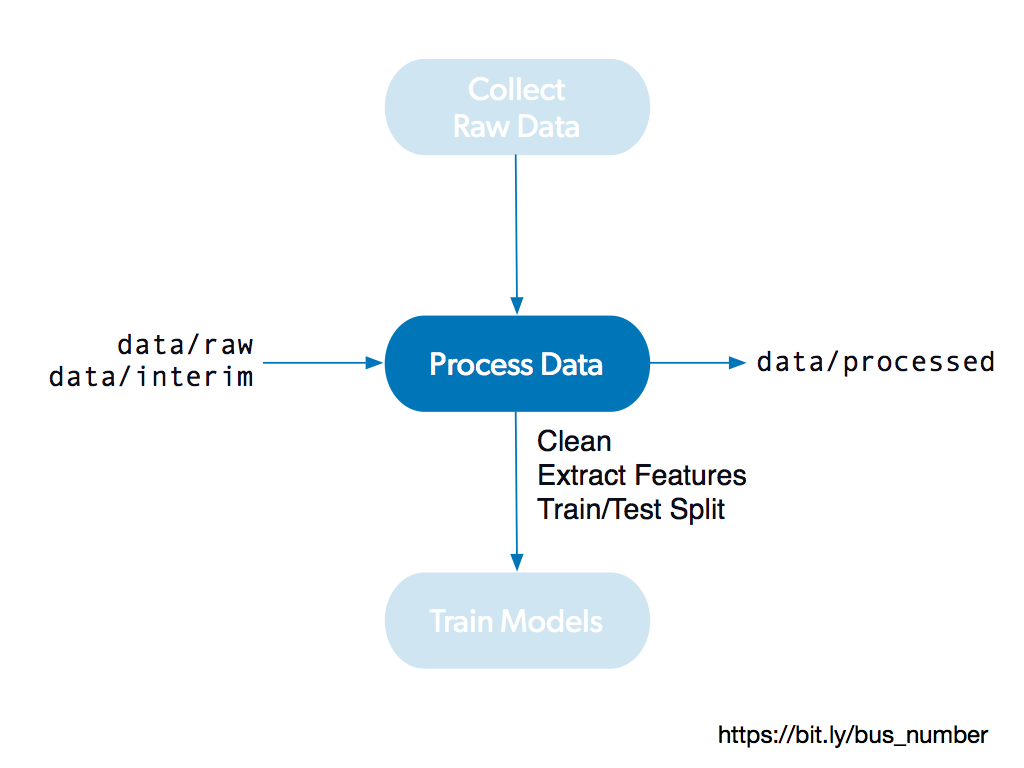

The next step is to write the importer that actually processes the data we will be using for this dataset.

The important things to generate are `data` and `target` entries. A `metadata` is optional, but recommended if you want to save additional information about the dataset.

Usually, this functionality gets bundled up into a function and added to `datasets.py`

Let's find our dataset.

In [ ]:
unpack_dir = untar_dir / 'lvq_pak-3.1'
list_dir(unpack_dir)

In this dataset, the training and test datsets are stored in files named `ex1.dat` and `ex2.dat` respectively.

In [ ]:
# Unpack the file
untar_dir = lvq_pak.unpack()
list_dir(untar_dir)

In [ ]:
datafile_train = unpack_dir / 'ex1.dat'
datafile_test = unpack_dir / 'ex2.dat'

datafile_train.exists() and datafile_test.exists()

According to the documentation, the data format is space-delimited, with the class label included as the last column. Let's have a look.

In [ ]:
from src.utils import head_file

In [ ]:
print(head_file(datafile_train))

Indeed, the datafile consists of a single line containing the dimension of the data, a comment, and then 21 space-delimited columns, the final column being the target class label. 

**Note:** We have to be a little careful importing the data, because '#' is used both as the comment delimiter, and as a class label.

Fortunately, we have a helper function for this. We will get a little cheeky and skip the first 2 lines (hoping there are no other comments). The documentation also says ther are 1962 entries in each of the training and test datasets.

In [ ]:
def read_space_delimited(filename, skiprows=None, class_labels=True):
    """Read an space-delimited file

    skiprows: list of rows to skip when reading the file.

    Note: we can't use automatic comment detection, as
    `#` characters are also used as data labels.
    class_labels: boolean
        if true, the last column is treated as the class label
    """
    with open(filename, 'r') as fd:
        df = pd.read_table(fd, skiprows=skiprows, skip_blank_lines=True,
                           comment=None, header=None, sep=' ', dtype=str)
        # targets are last column. Data is everything else
        if class_labels is True:
            target = df.loc[:, df.columns[-1]].values
            data = df.loc[:, df.columns[:-1]].values
        else:
            data = df.values
            target = np.zeros(data.shape[0])
        return data, target


In [ ]:
data, target = read_space_delimited(datafile_train, skiprows=[0,1])
data2, target2 = read_space_delimited(datafile_test, skiprows=[0])

data.shape, target.shape, data2.shape, target2.shape

In [ ]:
target

This seems to work, so let's wrap this functionality up into a processing function.
By convention, a processing function takes a `dataset_name`, and any other options that may be useful for reading the data, and returns a dictionary that matches the `Dataset` constructor signature.

In addition, a processing function should accept `dataset_name` and `metadata` keywords. Any additional metadata should be added to the `metadata` object that is passed in.


In [ ]:
from src.data import Dataset
help(Dataset.__init__)

We will place this function in `localdata.py`, (and add it to `__all__`) to make it visible to our dataset code.

In [ ]:
#%%file ../src/data/localdata.py
"""
Custom dataset processing/generation functions should be added to this file
"""

from src.data.utils import read_space_delimited, normalize_labels
from src.paths import interim_data_path
import numpy as np

__all__ = ['process_lvq_pak']

def process_lvq_pak(dataset_name='lvq-pak', kind='all', numeric_labels=True, metadata=None):
    """
    kind: {'test', 'train', 'all'}, default 'all'
    numeric_labels: boolean (default: True)
        if set, target is a vector of integers, and label_map is created in the metadata
        to reflect the mapping to the string targets
    """
    
    untar_dir = interim_data_path / dataset_name
    unpack_dir = untar_dir / 'lvq_pak-3.1'

    if kind == 'train':
        data, target = read_space_delimited(unpack_dir / 'ex1.dat', skiprows=[0,1])
    elif kind == 'test':
        data, target = read_space_delimited(unpack_dir / 'ex2.dat', skiprows=[0])
    elif kind == 'all':
        data1, target1 = read_space_delimited(unpack_dir / 'ex1.dat', skiprows=[0,1])
        data2, target2 = read_space_delimited(unpack_dir / 'ex2.dat', skiprows=[0])
        data = np.vstack((data1, data2))
        target = np.append(target1, target2)
    else:
        raise Exception(f'Unknown kind: {kind}')

    if numeric_labels:
        if metadata is None:
            metadata = {}
        mapped_target, label_map = normalize_labels(target)
        metadata['label_map'] = label_map
        target = mapped_target

    dset_opts = {
        'dataset_name': dataset_name,
        'data': data,
        'target': target,
        'metadata': metadata
    }
    return dset_opts


Let's make sure this works as expected.

In [ ]:
from src.data import Dataset
from src.data.localdata import process_lvq_pak

for kind in ['train', 'test', 'all']:
    dset_opts = process_lvq_pak(kind=kind)
    dset = Dataset(**dset_opts)
    print(f'{kind}: data={dset.data.shape} target={dset.target.shape}')

This all looks good. We can add this process function to the built in workflow in order to automate `Dataset` creation.

## Adding this Dataset to the master dataset list
All the commands for manipulating the various lists of activities in our data science project are in a module called `workflow`

In [ ]:
from src import workflow

In [ ]:
help(workflow)

First, add this **processing function** to the `RawDataset`, then add the `RawDataset` to the global dataset list. 

In [ ]:
lvq_pak.load_function = process_lvq_pak

In [ ]:
workflow.add_raw_dataset(lvq_pak)

Finally, re-load the dataset and save a copy of it.

In [ ]:
lvq = Dataset.from_raw(dataset_name, force=True)
print(str(lvq))

Alternately, we can create an empty `transformer` to convert this RawDataset into a Dataset and save it

In [ ]:
workflow.add_transformer(from_raw=dataset_name)

In [ ]:
workflow.get_transformer_list()

By running `apply_transforms()` a complete dataset will be written to `processed_data_path`. 

In [ ]:
logger.setLevel(logging.INFO)
workflow.apply_transforms()

A copy of just the metadata is also stored, so that it may be quickly checked without loading the entire dataset:

In [ ]:
lvq_meta = Dataset.load(dataset_name, metadata_only=True)

In [ ]:
type(lvq_meta)

In [ ]:
print(lvq.DATA_HASH)

And even better, from now on, **anytime** we want to access this dataset, all we have to do now is load the dataset!

In [ ]:
lvq_from_file = Dataset.load(dataset_name)

In [ ]:
lvq_from_file.data.shape

## What you didn't realize you were automating

By adding `lvq-pak` and it's processing functions to the `workflow`, you've now completely automated the process of fetching, unpacking, processing and transforming your data. In fact, there are a bunch of `Makefile` targets that will now work.


    fetch_raw:
        $(PYTHON_INTERPRETER) -m src.data.make_dataset fetch

    unpack_raw:
        $(PYTHON_INTERPRETER) -m src.data.make_dataset unpack

    process_raw:
        $(PYTHON_INTERPRETER) -m src.data.make_dataset process

    ## Apply Transformations to produce fully processed Datsets
    transform_data:
        $(PYTHON_INTERPRETER) -m src.data.apply_transforms transformer_list.json

The main difference here, is that the make targets will run on everything (all different datasets) that you've added to your workflow. We'll see this in the next example.

In [ ]:
!cd .. && make fetch_raw

In [ ]:
!cd .. && make unpack_raw

In [ ]:
!cd .. && make process_raw

The above three make targets are wrapped up in a single target:

    ## Fetch, Unpack, and Process raw dataset files
    raw: requirements process_raw
    
**Note**: the `-n` option to `make` doesn't run any commands, just prints them.

In [ ]:
!cd .. && make -n raw

That wasn't all we did, we also transformed our data into a `Dataset` object.

In [ ]:
!cd .. && make transform_data

Finally, to run **everything** that we've done so far, all you need is:

    ## convert raw datasets into fully processed datasets
    data: raw transform_data

In [ ]:
!cd .. && make -n data

## Train/Test Split

Since the tasks we have for Bjørn is to build a supervised model, we will undoubtably want to be able to create a train/test split. The default we had from downloading was a 50/50 split. But what if we actually want an 80/20 split?

Let's script this into the Dataset creation process.

We can  add a **transformer** that builds the train/test split. Since this is a transformation we want to do all the time, we already have one built in to do this.

In [ ]:
workflow.available_datasets()

In [ ]:
workflow.available_transformers()

In [ ]:
help(workflow.available_transformers(keys_only=False)['train_test_split'])

In [ ]:
workflow.get_transformer_list()

Let's add this transformer to re-split the `lvq-pak` data and add a new `Dataset`.

In [ ]:
transform_pipeline = [("train_test_split", {'random_state':6502, 'test_size':0.2})]
workflow.add_transformer(from_raw='lvq-pak',
                         suppress_output=True,
                         transformations=transform_pipeline)

In [ ]:
logger.setLevel(logging.INFO) # This step is a bit noisy, otherwise.
workflow.apply_transforms()
logger.setLevel(logging.DEBUG)

Notice there are now two new datasets: `lvq-pak_test` and `lvq-pak_train`

In [ ]:
workflow.available_datasets()

These datasets can now be loaded the way that `lvq-pak` could already be loaded.Furthermore, the metadata now reflects the options that were used to generate this split.

In [ ]:
ds = Dataset.load('lvq-pak_train')
ds.SPLIT_OPTS

In general, any other munging that we want to do to our data can be done via a **transformer**. That way, our RawDataset stays **read-only**, and all of our munging is scripted and reproducible. Furthermore, we can also easily access our transformed data whenever we need to.



## Cheat Sheet of what you did

Recall that overall we were going to:

1. Assemble the raw data files. Generate (and record) hashes to ensure the validity of these files.
2. Add LICENSE and DESCR (description) metadata to make the raw data usable for other people, and
3. Write a function to process the raw data into a usable format (for us, a `Dataset` object)
4. Write transformation functions on `Dataset` objects that fit our data munging into an automated reproducible workflow

In practice, that means:

* Create a `RawDataset`
    * `add_url()`: give instructions for how to `fetch` your data and add a `DESCR` and `LICENSE`
    * `add_process()`: add a function that knows how to process your specific dataset
* `workflow.add_raw_dataset()`: add the `RawDataset` to your `workflow`
* Transform your `Dataset`
    * (Optionally add a `transformer` function to the `workflow`)
    * `workflow.add_transformer()`: further transform your data. We used two, the empty transform, and the `train_test_split` transformer.
* Run `make data`

You can now `Dataset.load()` your `lvq-pak_train`, `lvq-pak_test`, and `lvq-pak` datsets.

### Check in the new `raw_datasets.json`, `transformer_list.json`
Under the hood, the all the elements to the `workflow` are being saved in `.json`. In particular:
* `make raw`: `raw_datasets.json`
* `make data`:  `transformer_list.json`

Because you're using `git` to keep track of your workflow, and you've been checking in your changes along the way...it's time to check your latest changes in! That means checking in the `.json` files that keep track of what your data-related `make` targets are going to do.

Cheat sheet:

    git add -p src/data/raw_datasets.json
    git add -p src/data/transformer_list.json
    git commit -m "(your commit message)"
    
Your project now generates its usable datasets from raw files. And it's all checked into source control and automated using `Makefile` targets.

## Welcome to reproducible data science!##


Normally, we'd also write tests to go with this...but due to time constraints, we'll skip that today...bonus materials to go with this tutorial will have some examples for what we would do to add tests to this example!